# 20241014

### 1. Adding 1.0 on y-axis (enhancement factor for all plots) ✅
### 2. Fitting first then finding true resonance and then recentering all plots where relevant ✅
### 3. Recalculate inhomogenous broadening with ~1mm blue MOT diameter ✅

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.signal import find_peaks
from ShelvingAnalysis import ShelvingAnalysis
from tqdm.notebook import tqdm

df1 = pd.read_csv('ShelvingIntensityRawDataAmp10.csv')
ShelvingIntensityAverageArray1 = df1['ShelvingIntensityAverageAmp10'].tolist()
ShelvingIntensityUncertaintyArray1 = df1['ShelvingIntensityUncertaintyAmp10'].tolist()
ShelvingIntensityAverageArray_cleaned1 = np.delete(ShelvingIntensityAverageArray1, [11,22,33,44,55,66,77,88])
ShelvingIntensityUncertaintyArray_cleaned1 = np.delete(ShelvingIntensityUncertaintyArray1, [11,22,33,44,55,66,77,88])

df2 = pd.read_csv('ShelvingIntensityRawDataAmp05.csv')
ShelvingIntensityAverageArray2 = df2['ShelvingIntensityAverageAmp05'].tolist()
ShelvingIntensityUncertaintyArray2 = df2['ShelvingIntensityUncertaintyAmp05'].tolist()
ShelvingIntensityAverageArray_cleaned2 = np.delete(ShelvingIntensityAverageArray2, [11,22,33,44,55,66,77,88])
ShelvingIntensityUncertaintyArray_cleaned2 = np.delete(ShelvingIntensityUncertaintyArray2, [11,22,33,44,55,66,77,88])

df3 = pd.read_csv('ShelvingIntensityRawDataAmp025.csv')
ShelvingIntensityAverageArray3 = df3['ShelvingIntensityAverageAmp025'].tolist()
ShelvingIntensityUncertaintyArray3 = df3['ShelvingIntensityUncertaintyAmp025'].tolist()
ShelvingIntensityAverageArray_cleaned3 = np.delete(ShelvingIntensityAverageArray3, [11,22,33,44,55,66])
ShelvingIntensityUncertaintyArray_cleaned3 = np.delete(ShelvingIntensityUncertaintyArray3, [11,22,33,44,55,66])

In [2]:
## WINDOWS: On your .ipynb, import this plotting_style by adding in and uncommenting the following lines:
# import matplotlib.pyplot as plt
# import sys
# sys.path.append('C:/Users/Michael/Dropbox/AION/Projects')  # Replace with the relevant path that contains this script
# from plotting_style_arial import set_plotting_style_arial
# set_plotting_style_arial()

## MAC: On your .ipynb, import this plotting_style by adding in and uncommenting the following lines:
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/michael/Dropbox/AION/Projects')  # Replace with the relevant path that contains this script
from plotting_style_arial import set_plotting_style_arial
set_plotting_style_arial()


import matplotlib.pyplot as plt

print('Initialising arial plotting style...')

def set_plotting_style_arial():
    plt.rc("font", family = 'Arial', size=10)
    plt.rc('axes', labelsize=20, titlesize = 20, labelpad=5)
    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=18)
    plt.rc('legend', fontsize=15)

print('Success! Arial plotting style initialised.')

Initialising arial plotting style...
Success! Arial plotting style initialised.
Initialising arial plotting style...
Success! Arial plotting style initialised.


<ErrorbarContainer object of 3 artists>

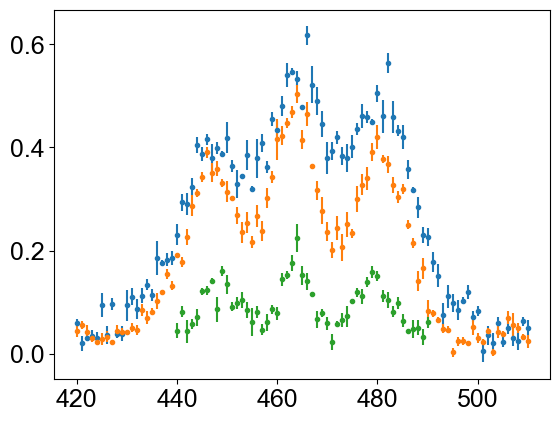

In [3]:
# Test plot with Mirny values to ensure consistency

plt.errorbar(np.arange(420, 511), ShelvingIntensityAverageArray_cleaned1, yerr=ShelvingIntensityUncertaintyArray_cleaned1, fmt='.', label=r'4.1$\times$10$^4$ $I_{s,red}$')
plt.errorbar(np.arange(420, 511), ShelvingIntensityAverageArray_cleaned2, yerr=ShelvingIntensityUncertaintyArray_cleaned2, fmt='.', label=r'1.9$\times$10$^4$ $I_{s,red}$')
plt.errorbar(np.arange(440, 511)[:-20], ShelvingIntensityAverageArray_cleaned3[:-20], yerr=ShelvingIntensityUncertaintyArray_cleaned3[:-20], fmt='.', label=r'1.6$\times$10$^3$ $I_{s,red}$')

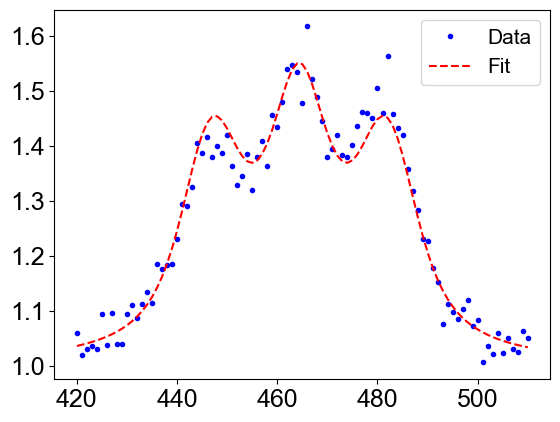

Fitted parameters:  [1.18584376e+01 4.64373918e+02 1.17004882e-02 8.03057882e+00
 7.43218831e+00 1.75959466e+01 3.00028957e+00 5.37403967e+00]
Amplitude of the central Voigt profile: 11.858437575679591
Central frequency of the central Voigt profile: 464.3739180789724
Standard deviation of the Gaussian part of the central Voigt profile: 0.011700488157635587
Half-width at half-maximum of the Lorentzian part of the central Voigt profile: 8.030578823097065
Amplitude of the side Voigt profiles: 7.432188314602234
Frequency separation of the side Voigt profiles from the central frequency: 17.595946580591434
Standard deviation of the Gaussian part of the side Voigt profiles: 3.0002895663056175
Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: 5.37403966753749
Standard deviations:  [5.61424810e+00 1.92314184e-01 7.48267330e+02 5.31801214e+00
 2.49811887e+00 5.55002297e-01 1.13708173e+00 1.93321753e+00]
Standard deviation of the amplitude of the central Voigt profile:

In [4]:
# fit amp1.0 plot

import numpy as np
from scipy.special import wofz
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the Voigt profile
def voigt(x, amp, mu, sigma, gamma):
    z = ((x - mu) + 1j*gamma) / (sigma * np.sqrt(2))
    return amp * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi)) # The +1 is to shift the Voigt profile up by 1

# Define a combination of three Voigt profiles: one central and two side ones
def combined_voigt(x, amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s):
    # Central Voigt profile
    central = voigt(x, amp_c, mu_c, sigma_c, gamma_c)
    # Side Voigt profiles (symmetrically placed)
    side_left = voigt(x, amp_s, mu_c - delta_s, sigma_s, gamma_s)
    side_right = voigt(x, amp_s, mu_c + delta_s, sigma_s, gamma_s)
    # Combine them
    return central + side_left + side_right

# Data to be fitted
x_data1 = np.arange(420, 511)
y_data = ShelvingIntensityAverageArray_cleaned1

# Initial guesses for fitting parameters: [amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s]
# The fitting parameters are in the order of the function arguments, explained below:
# amp_c: amplitude of the central Voigt profile
# mu_c: central frequency of the central Voigt profile
# sigma_c: standard deviation of the Gaussian part of the central Voigt profile
# gamma_c: half-width at half-maximum of the Lorentzian part of the central Voigt profile
# amp_s: amplitude of the side Voigt profiles
# delta_s: frequency separation of the side Voigt profiles from the central frequency
# sigma_s: standard deviation of the Gaussian part of the side Voigt profiles
# gamma_s: half-width at half-maximum of the Lorentzian part of the side Voigt profiles
initial_guesses = [1.0, 460.0, 1.0, 0.5, 0.5, 5.0, 1.0, 0.5]

# Fit the combined Voigt profile to the data
popt1, pcov1 = curve_fit(combined_voigt, x_data1, y_data, p0=initial_guesses)

# Plot the result
plt.plot(x_data1, y_data + 1, 'b.', label='Data')
plt.plot(x_data1, combined_voigt(x_data1, *popt1) + 1, 'r--', label='Fit')
plt.legend()
plt.show()

# Print the fitted parameters
print("Fitted parameters: ", popt1)

# List them out individually
print(f"Amplitude of the central Voigt profile: {popt1[0]}")
print(f"Central frequency of the central Voigt profile: {popt1[1]}")
print(f"Standard deviation of the Gaussian part of the central Voigt profile: {popt1[2]}")
print(f"Half-width at half-maximum of the Lorentzian part of the central Voigt profile: {popt1[3]}")
print(f"Amplitude of the side Voigt profiles: {popt1[4]}")
print(f"Frequency separation of the side Voigt profiles from the central frequency: {popt1[5]}")
print(f"Standard deviation of the Gaussian part of the side Voigt profiles: {popt1[6]}")
print(f"Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {popt1[7]}")

# Extract the pcov diagonal to get the standard deviations of the fitted parameters
perr1 = np.sqrt(np.diag(pcov1))

# Print the standard deviations
print("Standard deviations: ", perr1)

# List them out individually
print(f"Standard deviation of the amplitude of the central Voigt profile: {perr1[0]}")
print(f"Standard deviation of the central frequency of the central Voigt profile: {perr1[1]}")
print(f"Standard deviation of the standard deviation of the Gaussian part of the central Voigt profile: {perr1[2]}")
print(f"Standard deviation of the half-width at half-maximum of the Lorentzian part of the central Voigt profile: {perr1[3]}")
print(f"Standard deviation of the amplitude of the side Voigt profiles: {perr1[4]}")
print(f"Standard deviation of the frequency separation of the side Voigt profiles from the central frequency: {perr1[5]}")
print(f"Standard deviation of the standard deviation of the Gaussian part of the side Voigt profiles: {perr1[6]}")
print(f"Standard deviation of the half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {perr1[7]}")


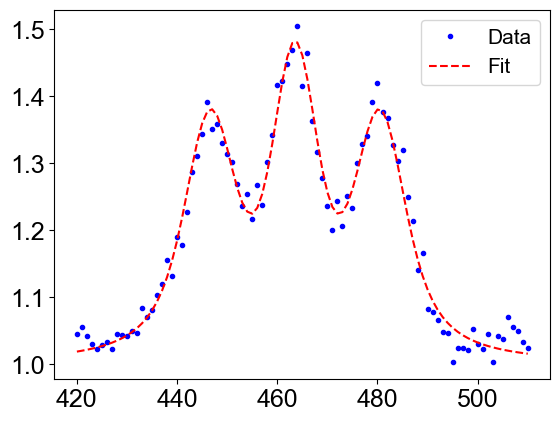

Fitted parameters:  [  5.69682419 463.54347297   3.19567979   2.54812568   6.44547043
  16.97107992   2.62889423   4.74305612]
Amplitude of the central Voigt profile: 5.696824194567101
Central frequency of the central Voigt profile: 463.54347297311995
Standard deviation of the Gaussian part of the central Voigt profile: 3.195679787647414
Half-width at half-maximum of the Lorentzian part of the central Voigt profile: 2.548125684145897
Amplitude of the side Voigt profiles: 6.445470425799375
Frequency separation of the side Voigt profiles from the central frequency: 16.971079916628728
Standard deviation of the Gaussian part of the side Voigt profiles: 2.6288942310466594
Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: 4.743056123435731
Standard deviations of the fitted parameters:  [1.46005187 0.10857449 1.50159793 2.61836978 0.70537883 0.30244805
 0.64402425 0.65216408]
Standard deviation of the amplitude of the central Voigt profile: 1.460051873620839
Standa

In [5]:
#fit amp0.5 plot

import numpy as np
from scipy.special import wofz
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the Voigt profile
def voigt(x, amp, mu, sigma, gamma):
    z = ((x - mu) + 1j*gamma) / (sigma * np.sqrt(2))
    return amp * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))

# Define a combination of three Voigt profiles: one central and two side ones
def combined_voigt(x, amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s):
    # Central Voigt profile
    central = voigt(x, amp_c, mu_c, sigma_c, gamma_c)
    # Side Voigt profiles (symmetrically placed)
    side_left = voigt(x, amp_s, mu_c - delta_s, sigma_s, gamma_s)
    side_right = voigt(x, amp_s, mu_c + delta_s, sigma_s, gamma_s)
    # Combine them
    return central + side_left + side_right

# Generate some synthetic data (for demonstration)
x_data2 = np.arange(420, 511)
y_data = ShelvingIntensityAverageArray_cleaned2

# Initial guesses for fitting parameters: [amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s]
# The fitting parameters are in the order of the function arguments, explained below:
# amp_c: amplitude of the central Voigt profile
# mu_c: central frequency of the central Voigt profile
# sigma_c: standard deviation of the Gaussian part of the central Voigt profile
# gamma_c: half-width at half-maximum of the Lorentzian part of the central Voigt profile
# amp_s: amplitude of the side Voigt profiles
# delta_s: frequency separation of the side Voigt profiles from the central frequency
# sigma_s: standard deviation of the Gaussian part of the side Voigt profiles
# gamma_s: half-width at half-maximum of the Lorentzian part of the side Voigt profiles
initial_guesses = [1.0, 460.0, 1.0, 0.5, 0.5, 5.0, 1.0, 0.5]

# Fit the combined Voigt profile to the data
popt2, pcov2 = curve_fit(combined_voigt, x_data2, y_data, p0=initial_guesses)

# Plot the result
plt.plot(x_data2, y_data + 1, 'b.', label='Data')
plt.plot(x_data2, combined_voigt(x_data2, *popt2) + 1, 'r--', label='Fit')
plt.legend()
plt.show()


# Print the fitted parameters
print("Fitted parameters: ", popt2)

# List them out individually
print(f"Amplitude of the central Voigt profile: {popt2[0]}")
print(f"Central frequency of the central Voigt profile: {popt2[1]}")
print(f"Standard deviation of the Gaussian part of the central Voigt profile: {popt2[2]}")
print(f"Half-width at half-maximum of the Lorentzian part of the central Voigt profile: {popt2[3]}")
print(f"Amplitude of the side Voigt profiles: {popt2[4]}")
print(f"Frequency separation of the side Voigt profiles from the central frequency: {popt2[5]}")
print(f"Standard deviation of the Gaussian part of the side Voigt profiles: {popt2[6]}")
print(f"Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {popt2[7]}")

# Extract the pcov diagonal to get the standard deviations of the fitted parameters
perr2 = np.sqrt(np.diag(pcov2))
print("Standard deviations of the fitted parameters: ", perr2)

# List them out individually
print(f"Standard deviation of the amplitude of the central Voigt profile: {perr2[0]}")
print(f"Standard deviation of the central frequency of the central Voigt profile: {perr2[1]}")
print(f"Standard deviation of the standard deviation of the Gaussian part of the central Voigt profile: {perr2[2]}")
print(f"Standard deviation of the half-width at half-maximum of the Lorentzian part of the central Voigt profile: {perr2[3]}")
print(f"Standard deviation of the amplitude of the side Voigt profiles: {perr2[4]}")
print(f"Standard deviation of the frequency separation of the side Voigt profiles from the central frequency: {perr2[5]}")
print(f"Standard deviation of the standard deviation of the Gaussian part of the side Voigt profiles: {perr2[6]}")
print(f"Standard deviation of the half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {perr2[7]}")

# Find the full width half maximum of the central voigt profile for amp 0.5

def FWHM_voigt(sigma, gamma):
    return 1.069*gamma + np.sqrt(0.866*gamma**2 + 5.55*sigma**2)

FWHM05_central = FWHM_voigt(popt2[2], popt2[3])
FWHM05_side = FWHM_voigt(popt2[6], popt2[7])

print(f"FWHM of the central Voigt profile for amp0.5: {FWHM05_central}")

print(f"FWHM of the side Voigt profiles for amp0.5: {FWHM05_side}")

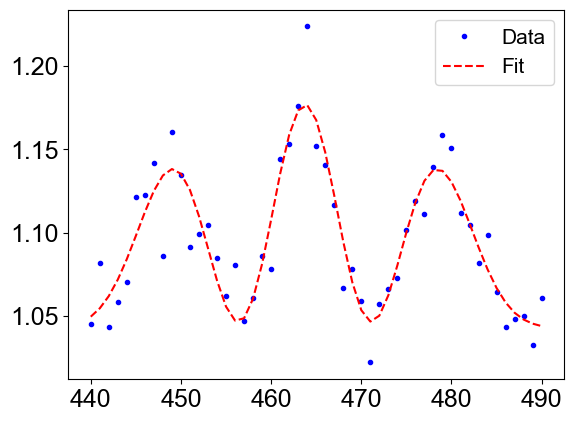

Fitted parameters:  [ 8.48096709e+00  4.63758524e+02  2.67783305e-02  1.94587415e+01
 -4.38283041e-02  5.97210289e+00  8.47628560e+00 -2.16058292e+01]
Amplitude of the central Voigt profile: 8.480967085626448
Central frequency of the central Voigt profile: 463.7585239879327
Standard deviation of the Gaussian part of the central Voigt profile: 0.0267783305412779
Half-width at half-maximum of the Lorentzian part of the central Voigt profile: 19.45874151921011
Amplitude of the side Voigt profiles: -0.04382830410242819
Frequency separation of the side Voigt profiles from the central frequency: 5.972102891748413
Standard deviation of the Gaussian part of the side Voigt profiles: 8.476285602439955
Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: -21.605829225075773
Standard deviations:  [2.63336402e+01 1.86315002e-01 5.97264231e+04 1.72481437e+02
 7.58738161e-01 8.95261502e+00 3.70211347e+00 4.76774061e+01]
Standard deviation of the amplitude of the central Voigt

In [6]:
# fit amp0.25 plot

import numpy as np
from scipy.special import wofz
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the Voigt profile
def voigt(x, amp, mu, sigma, gamma):
    z = ((x - mu) + 1j*gamma) / (sigma * np.sqrt(2))
    return amp * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))

# Define a combination of three Voigt profiles: one central and two side ones
def combined_voigt(x, amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s):
    # Central Voigt profile
    central = voigt(x, amp_c, mu_c, sigma_c, gamma_c)
    # Side Voigt profiles (symmetrically placed)
    side_left = voigt(x, amp_s, mu_c - delta_s, sigma_s, gamma_s)
    side_right = voigt(x, amp_s, mu_c + delta_s, sigma_s, gamma_s)
    # Combine them
    return central + side_left + side_right

# Generate some synthetic data (for demonstration)
x_data3 = np.arange(440, 511)[:-20]
y_data = ShelvingIntensityAverageArray_cleaned3[:-20]

# Initial guesses for fitting parameters: [amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s]
# The fitting parameters are in the order of the function arguments, explained below:
# amp_c: amplitude of the central Voigt profile
# mu_c: central frequency of the central Voigt profile
# sigma_c: standard deviation of the Gaussian part of the central Voigt profile
# gamma_c: half-width at half-maximum of the Lorentzian part of the central Voigt profile
# amp_s: amplitude of the side Voigt profiles
# delta_s: frequency separation of the side Voigt profiles from the central frequency
# sigma_s: standard deviation of the Gaussian part of the side Voigt profiles
# gamma_s: half-width at half-maximum of the Lorentzian part of the side Voigt profiles
initial_guesses = [0.2, 460.0, 1.0, 0.5, 0.5, 1.0, 1.0, 0.5]

# Fit the combined Voigt profile to the data
popt3, pcov3 = curve_fit(combined_voigt, x_data3, y_data, p0=initial_guesses)

# Plot the result
plt.plot(x_data3, y_data + 1, 'b.', label='Data')
plt.plot(x_data3, combined_voigt(x_data3, *popt3) + 1, 'r--', label='Fit')
plt.legend()
plt.show()

# Print the fitted parameters
print("Fitted parameters: ", popt3)

# List them out individually
print(f"Amplitude of the central Voigt profile: {popt3[0]}")
print(f"Central frequency of the central Voigt profile: {popt3[1]}")
print(f"Standard deviation of the Gaussian part of the central Voigt profile: {popt3[2]}")
print(f"Half-width at half-maximum of the Lorentzian part of the central Voigt profile: {popt3[3]}")
print(f"Amplitude of the side Voigt profiles: {popt3[4]}")
print(f"Frequency separation of the side Voigt profiles from the central frequency: {popt3[5]}")
print(f"Standard deviation of the Gaussian part of the side Voigt profiles: {popt3[6]}")
print(f"Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {popt3[7]}")

# Extract the pcov diagonal to get the standard deviations of the fitted parameters
perr3 = np.sqrt(np.diag(pcov3))

# Print the standard deviations
print("Standard deviations: ", perr3)

# List them out individually
print(f"Standard deviation of the amplitude of the central Voigt profile: {perr3[0]}")
print(f"Standard deviation of the central frequency of the central Voigt profile: {perr3[1]}")
print(f"Standard deviation of the standard deviation of the Gaussian part of the central Voigt profile: {perr3[2]}")
print(f"Standard deviation of the half-width at half-maximum of the Lorentzian part of the central Voigt profile: {perr3[3]}")
print(f"Standard deviation of the amplitude of the side Voigt profiles: {perr3[4]}")
print(f"Standard deviation of the frequency separation of the side Voigt profiles from the central frequency: {perr3[5]}")
print(f"Standard deviation of the standard deviation of the Gaussian part of the side Voigt profiles: {perr3[6]}")
print(f"Standard deviation of the half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {perr3[7]}")

Text(0.5, 0, 'Frequency detuning (MHz)')

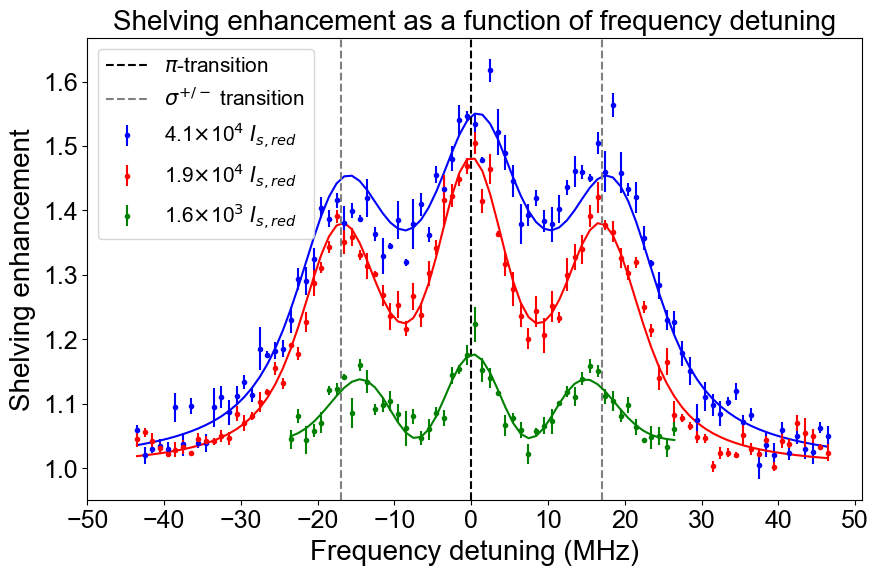

In [7]:
# Use the fitted parameters to determine true resonance, using amp05 as the central frequency

resonance_frequency = popt2[1]

# Now shift all the x-axis data points by setting resonance_frequency as 0 and shifting all other frequencies by the same amount

x_data1_shifted = x_data1 - resonance_frequency
x_data2_shifted = x_data2 - resonance_frequency
x_data3_shifted = x_data3 - resonance_frequency

# Plot the shifted data

plt.figure(figsize=(10, 6))

plt.errorbar(x_data1_shifted, ShelvingIntensityAverageArray_cleaned1 + 1, ShelvingIntensityUncertaintyArray_cleaned1, fmt='.', color='blue', label=r'4.1$\times$10$^4$ $I_{s,red}$')
plt.plot(x_data1_shifted, combined_voigt(x_data1, *popt1) + 1, 'b-')

plt.errorbar(x_data2_shifted, ShelvingIntensityAverageArray_cleaned2 + 1, ShelvingIntensityUncertaintyArray_cleaned2, fmt='.', color='red', label=r'1.9$\times$10$^4$ $I_{s,red}$')
plt.plot(x_data2_shifted, combined_voigt(x_data2, *popt2) + 1, 'r-')
plt.axvline(0, color='k', linestyle='--', label=r'$\pi$-transition')
plt.axvline(popt2[5], color='grey', linestyle='--', label = r'$\sigma^{+/-}$ transition')
plt.axvline(-popt2[5], color='grey', linestyle='--')

# Plot a horizontal line via annotation with double-sided arrows
# plt.annotate(
#     '', xy=(popt2[5], 1.625), xytext=(-popt2[5], 1.625),
#     arrowprops=dict(arrowstyle='<->', color='black')
# )
# plt.text(0, 1.625, '33.94MHz', ha='center',va='bottom', color='black', fontsize=14)

plt.errorbar(x_data3_shifted, ShelvingIntensityAverageArray_cleaned3[:-20] + 1, ShelvingIntensityUncertaintyArray_cleaned3[:-20], fmt='.', color='green', label=r'1.6$\times$10$^3$ $I_{s,red}$')
plt.plot(x_data3_shifted, combined_voigt(x_data3, *popt3) + 1, 'g-')

plt.xticks(np.arange(-50, 51, 10))
plt.legend(loc='upper left')

plt.title('Shelving enhancement as a function of frequency detuning')
plt.ylabel(r'Shelving enhancement')
plt.xlabel(r'Frequency detuning (MHz)')

# plt.savefig('ShelvingEnhancementVsFrequencyDetuningFitted_20241021.png', dpi=300)
# plt.savefig('ShelvingEnhancementVsFrequencyDetuningFitted_20241021.pdf',dpi=1200)

# 20250420 Change to nice LaTEX font

In [8]:
# copy paste this code to the beginning of your script to set the plotting style for a one column figure

from matplotlib import pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "figure.constrained_layout.use": True
})

plt.rcParams["savefig.bbox"] = None
plt.rcParams["figure.figsize"] = (5.9,3.5)  # (width, height) in inches, change height but not width
plt.rcParams["figure.titlesize"] = 10 # this is only for plt.suptitle, i set it to be the same as the rest

plt.rcParams["axes.titlesize"] = 10 # control title size
plt.rcParams["axes.labelsize"] = 10 # control x and y axis labels
plt.rcParams["axes.labelpad"] = 4.0 # distance between axis label and axis numbers
plt.rcParams["xtick.labelsize"] = 10 # independent control of xlabel fontsize
plt.rcParams["ytick.labelsize"] = 10 # independent control of ylabel fontsize

plt.rcParams["legend.fontsize"] = 7.5 # control legend size, I set it to be slightly smaller than title/axes label
# plt.rcParams["legend.facecolor"] = (0.9, 0.9, 0.9) # legend background color
# plt.rcParams["legend.edgecolor"] = (0, 0, 0) # legend border line color
# plt.rcParams["legend.frameon"] = True # whether or not to draw a border around legend
# plt.rcParams["legend.framealpha"] = 0.1 # legend background transparency
plt.rcParams["legend.loc"] = "best" # default legend location
plt.rcParams["legend.handletextpad"] = 0.8  # Horizontal space between legend point and text (default 0.8)
plt.rcParams["legend.labelspacing"] = 0.6  # Vertical space between legend entries (default 0.5)
# plt.rcParams["legend.columnspacing"] = 2.0  # Space between columns in multi-column legends
# plt.rcParams["legend.borderpad"] = 1.0  # Space between legend content and the box
# plt.rcParams["legend.handlelength"] = 2.0  # Length of legend marker lines

plt.rcParams["lines.linewidth"] = 1
# plt.rcParams["lines.markeredgewidth"] = 0.7
plt.rcParams["lines.markersize"] = 6 #data point size

plt.rcParams["grid.linestyle"] = "-"
plt.rcParams['axes.grid'] = False
# plt.rcParams["grid.linewidth"] = 0.7

# plt.rcParams["xtick.major.pad"] = 4.0 # distance between xticks dashes and xaxis numbers
# plt.rcParams["xtick.major.size"] = 3.0
# plt.rcParams["xtick.major.width"] = 0.7
# plt.rcParams["ytick.major.pad"] = 4.0 # distance between yticks dashes and yaxis numbers
# plt.rcParams["ytick.major.size"] = 3.0
# plt.rcParams["ytick.major.width"] = 0.7

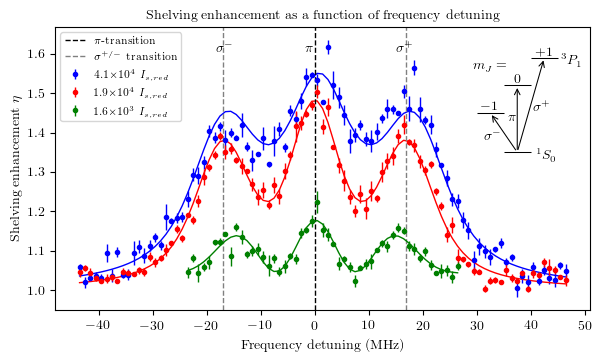

In [115]:
# Use the fitted parameters to determine true resonance, using amp05 as the central frequency

resonance_frequency = popt2[1]

# Now shift all the x-axis data points by setting resonance_frequency as 0 and shifting all other frequencies by the same amount

x_data1_shifted = x_data1 - resonance_frequency
x_data2_shifted = x_data2 - resonance_frequency
x_data3_shifted = x_data3 - resonance_frequency

# Plot the shifted data

# CHOOSE NICE COLOR FROM "dodgerblue","mediumseagreen","indianred","mediumpurple","slateblue","darkorange","peru","goldenrod"

plt.errorbar(x_data1_shifted, ShelvingIntensityAverageArray_cleaned1 + 1, ShelvingIntensityUncertaintyArray_cleaned1, fmt='.', color='blue', label=r'4.1$\times$10$^4$ $I_{s,red}$')
plt.plot(x_data1_shifted, combined_voigt(x_data1, *popt1) + 1, 'b-')

plt.errorbar(x_data2_shifted, ShelvingIntensityAverageArray_cleaned2 + 1, ShelvingIntensityUncertaintyArray_cleaned2, fmt='.', color='red', label=r'1.9$\times$10$^4$ $I_{s,red}$')
plt.plot(x_data2_shifted, combined_voigt(x_data2, *popt2) + 1, 'r-')
plt.axvline(0, color='k', linestyle='--', label=r'$\pi$-transition')
plt.axvline(popt2[5], color='grey', linestyle='--', label = r'$\sigma^{+/-}$ transition')
plt.axvline(-popt2[5], color='grey', linestyle='--')

# Plot a horizontal line via annotation with double-sided arrows
# plt.annotate(
#     '', xy=(popt2[5], 1.625), xytext=(-popt2[5], 1.625),
#     arrowprops=dict(arrowstyle='<->', color='black')
# )
# plt.text(0, 1.625, '33.94MHz', ha='center',va='bottom', color='black', fontsize=14)

plt.errorbar(x_data3_shifted, ShelvingIntensityAverageArray_cleaned3[:-20] + 1, ShelvingIntensityUncertaintyArray_cleaned3[:-20], fmt='.', color='green', label=r'1.6$\times$10$^3$ $I_{s,red}$')
plt.plot(x_data3_shifted, combined_voigt(x_data3, *popt3) + 1, 'g-')

plt.xticks(np.arange(-50, 51, 10))
plt.legend(loc='upper left')

plt.title('Shelving enhancement as a function of frequency detuning')
plt.ylabel(r'Shelving enhancement $\eta$')
plt.xlabel(r'Frequency detuning (MHz)')

plt.text(-16.7, 1.6, r"$\sigma^-$", ha='center', va='bottom')
plt.text(16.7, 1.6, r"$\sigma^+$", ha='center', va='bottom')
plt.text(-1, 1.6, r"$\pi$", ha='center', va='bottom')

# Coordinates for the three top lines
top_y = 1.45
dy = 0.07
top_xs = [30, 35, 40]
line_length = 5

# Draw the three top lines
for i, x in enumerate(top_xs):
    plt.hlines(top_y + i*dy, x, x + line_length, color='black', linewidth=0.75)

# Draw the bottom line
bottom_y = top_y - 0.1
bottom_x = 35
plt.hlines(bottom_y, bottom_x, bottom_x + line_length, color='black', linewidth=0.75)

# Draw arrows from bottom line to each top line
arrowprops = dict(arrowstyle='->', color='black', linewidth=0.75)
for i, x in enumerate(top_xs):
    plt.annotate(
        '', 
        xy=(x + line_length/2, top_y + i*dy), 
        xytext=(bottom_x + line_length/2, bottom_y), 
        arrowprops=arrowprops
    )

plt.text(33, 1.425-0.05, r"$\sigma^-$", ha='center', va='bottom')
plt.text(42, 1.5-0.05, r"$\sigma^+$", ha='center', va='bottom')
plt.text(36.5, 1.475-0.05, r"$\pi$", ha='center', va='bottom')
plt.text(43, bottom_y+0.01, r"$^1S_0$", ha='center', va='top')
plt.text(48-0.5, bottom_y+0.01+0.24, r"$^3P_1$", ha='center', va='top')
plt.text(32.5, top_y, r"$-1$", ha='center', va='bottom')
plt.text(37.5, top_y+dy, r"$0$", ha='center', va='bottom')
plt.text(37.5+5, top_y+dy+dy, r"$+1$", ha='center', va='bottom')
plt.text(32.5, top_y+dy+0.5*dy, r"$m_J=$", ha='center', va='bottom')

# plt.savefig('ShelvingEnhancementVsFrequencyDetuningFitted_20241021.png', dpi=300)
plt.savefig('ShelvingEnhancementVsFrequencyDetuningFitted_20250420.pdf',dpi=300)

# 20240829

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.signal import find_peaks
from ShelvingAnalysis import ShelvingAnalysis
from tqdm.notebook import tqdm

df1 = pd.read_csv('ShelvingIntensityRawDataAmp10.csv')
ShelvingIntensityAverageArray1 = df1['ShelvingIntensityAverageAmp10'].tolist()
ShelvingIntensityUncertaintyArray1 = df1['ShelvingIntensityUncertaintyAmp10'].tolist()
ShelvingIntensityAverageArray_cleaned1 = np.delete(ShelvingIntensityAverageArray1, [11,22,33,44,55,66,77,88])
ShelvingIntensityUncertaintyArray_cleaned1 = np.delete(ShelvingIntensityUncertaintyArray1, [11,22,33,44,55,66,77,88])

df2 = pd.read_csv('ShelvingIntensityRawDataAmp05.csv')
ShelvingIntensityAverageArray2 = df2['ShelvingIntensityAverageAmp05'].tolist()
ShelvingIntensityUncertaintyArray2 = df2['ShelvingIntensityUncertaintyAmp05'].tolist()
ShelvingIntensityAverageArray_cleaned2 = np.delete(ShelvingIntensityAverageArray2, [11,22,33,44,55,66,77,88])
ShelvingIntensityUncertaintyArray_cleaned2 = np.delete(ShelvingIntensityUncertaintyArray2, [11,22,33,44,55,66,77,88])

df3 = pd.read_csv('ShelvingIntensityRawDataAmp025.csv')
ShelvingIntensityAverageArray3 = df3['ShelvingIntensityAverageAmp025'].tolist()
ShelvingIntensityUncertaintyArray3 = df3['ShelvingIntensityUncertaintyAmp025'].tolist()
ShelvingIntensityAverageArray_cleaned3 = np.delete(ShelvingIntensityAverageArray3, [11,22,33,44,55,66])
ShelvingIntensityUncertaintyArray_cleaned3 = np.delete(ShelvingIntensityUncertaintyArray3, [11,22,33,44,55,66])

ShelvingIntensityAverageArray_cleaned3_padded = np.pad(ShelvingIntensityAverageArray_cleaned3, (20,0), mode = 'constant', constant_values = 0)
ShelvingIntensityUncertaintyArray_cleaned3_padded = np.pad(ShelvingIntensityUncertaintyArray_cleaned3, (20,0), mode = 'constant', constant_values = 0)

In [2]:
### ---------------------- INITIALISE PLOTTING STYLE ---------------------- ###

## WINDOWS: On your .ipynb, import this plotting_style by adding in and uncommenting the following lines:
import matplotlib.pyplot as plt
import sys
sys.path.append('C:/Users/Michael/Dropbox/AION/Projects')  # Replace with the relevant path that contains this script
from plotting_style import set_plotting_style
set_plotting_style()

## MAC: On your .ipynb, import this plotting_style by adding in and uncommenting the following lines:
# import matplotlib.pyplot as plt
# import sys
# sys.path.append('/Users/michael/Dropbox/AION/Projects')  # Replace with the relevant path that contains this script
# from plotting_style import set_plotting_style
# set_plotting_style()


import matplotlib.pyplot as plt

print('Initialising plotting style...')

def set_plotting_style():
    plt.rc("font", family = 'Arial', size=10)
    plt.rc('axes', labelsize=20, titlesize = 20, labelpad=5)
    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=18)
    plt.rc('legend', fontsize=15)

print('Success! Plotting style initialised.')


Initialising plotting style...
Success! Plotting style initialised.
Initialising plotting style...
Success! Plotting style initialised.


Text(0.5, 0, 'Frequency Detuning ($\\times$10$^3$ $\\Gamma_{red}$)')

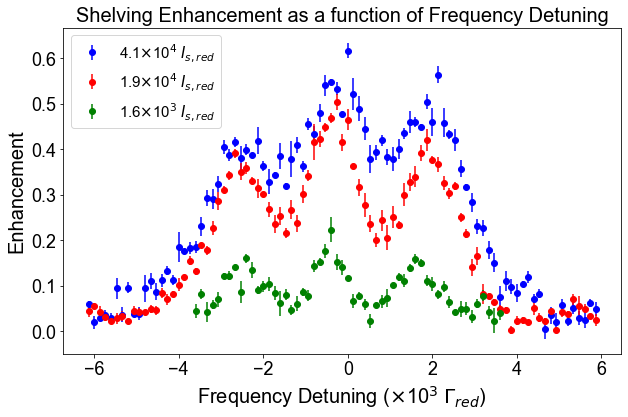

In [3]:
### ---------------------- PLOTTING ---------------------- ###

plt.figure(figsize=(10,6))

# convert x-axis to frequency detuning space in MHz, where the biggest shelving intensity is 0 detuning
FrequencyDetuning = np.arange(-np.argmax(ShelvingIntensityAverageArray_cleaned1), np.shape(ShelvingIntensityAverageArray_cleaned1)[0]-np.argmax(ShelvingIntensityAverageArray_cleaned1))
FrequencyDetuningGamma = FrequencyDetuning/7.5 # convert to units of x 10e3 Gamma_red (7.5kHz)

# plt.errorbar(range(len(ShelvingIntensityAverageArray)), ShelvingIntensityAverageArray, yerr=ShelvingIntensityUncertaintyArray, fmt='o')
plt.errorbar(FrequencyDetuningGamma, ShelvingIntensityAverageArray_cleaned1, yerr=ShelvingIntensityUncertaintyArray_cleaned1, fmt='o',color='blue', label=r'4.1$\times$10$^4$ $I_{s,red}$')
plt.errorbar(FrequencyDetuningGamma, ShelvingIntensityAverageArray_cleaned2, yerr=ShelvingIntensityUncertaintyArray_cleaned2, fmt='o', color='red', label=r'1.9$\times$10$^4$ $I_{s,red}$')
plt.errorbar(FrequencyDetuningGamma[-72:-17], ShelvingIntensityAverageArray_cleaned3[:-16], yerr=ShelvingIntensityUncertaintyArray_cleaned3[:-16], fmt='o', color='green',label=r'1.6$\times$10$^3$ $I_{s,red}$')
plt.legend(loc='upper left')

plt.title('Shelving Enhancement as a function of Frequency Detuning')
plt.ylabel(r'Enhancement')
plt.xlabel(r'Frequency Detuning ($\times$10$^3$ $\Gamma_{red}$)')

# plt.savefig('ShelvingEnhancementVsFrequencyDetuning.png', dpi=1200)
# plt.savefig('ShelvingEnhancementVsFrequencyDetuning.pdf',dpi=1200)

In [4]:
PowerAmp10 = 65 #mW
IntensityAmp10 = 2*PowerAmp10/(np.pi*0.58**2) #mW/cm^2
IntensityAmp10SaturationRed = IntensityAmp10*1e3/3

IntensityAmp10SaturationRed

41003.05707876813

In [5]:
IntensityAmp10

123.00917123630438

In [6]:
PowerAmp05 = 30 #mW
IntensityAmp05 = 2*PowerAmp05/(np.pi*0.58**2) #mW/cm^2
IntensityAmp05SaturationRed = IntensityAmp05*1e3/3

IntensityAmp05SaturationRed

18924.487882508365

In [7]:
IntensityAmp05

56.7734636475251

In [8]:
PowerAmp025 = 2.5 #mW
IntensityAmp025 = 2*PowerAmp025/(np.pi*0.58**2) #mW/cm^2
IntensityAmp025SaturationRed = IntensityAmp025*1e3/3

IntensityAmp025SaturationRed

1577.040656875697

In [9]:
IntensityAmp025

4.7311219706270915

Text(0.5, 0, 'Frequency Detuning (MHz)')

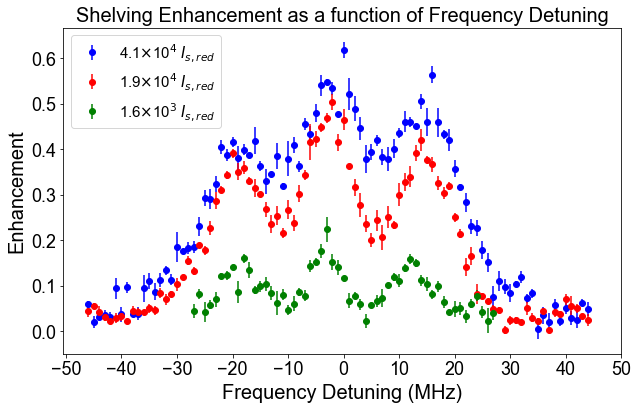

In [10]:
### ---------------------- PLOTTING ---------------------- ###

plt.figure(figsize=(10,6))

# convert x-axis to frequency detuning space in MHz, where the biggest shelving intensity is 0 detuning
FrequencyDetuning = np.arange(-np.argmax(ShelvingIntensityAverageArray_cleaned1), np.shape(ShelvingIntensityAverageArray_cleaned1)[0]-np.argmax(ShelvingIntensityAverageArray_cleaned1))
FrequencyDetuningGamma = FrequencyDetuning/7.5 # convert to units of x 10e3 Gamma_red (7.5kHz)

# plt.errorbar(range(len(ShelvingIntensityAverageArray)), ShelvingIntensityAverageArray, yerr=ShelvingIntensityUncertaintyArray, fmt='o')
plt.errorbar(FrequencyDetuning, ShelvingIntensityAverageArray_cleaned1, yerr=ShelvingIntensityUncertaintyArray_cleaned1, fmt='o',color='blue', label=r'4.1$\times$10$^4$ $I_{s,red}$')
plt.errorbar(FrequencyDetuning, ShelvingIntensityAverageArray_cleaned2, yerr=ShelvingIntensityUncertaintyArray_cleaned2, fmt='o', color='red', label=r'1.9$\times$10$^4$ $I_{s,red}$')
plt.errorbar(FrequencyDetuning[-72:-17], ShelvingIntensityAverageArray_cleaned3[:-16], yerr=ShelvingIntensityUncertaintyArray_cleaned3[:-16], fmt='o', color='green',label=r'1.6$\times$10$^3$ $I_{s,red}$')
plt.legend(loc='upper left')

plt.xticks(np.arange(-50, 51, 10))
plt.title('Shelving Enhancement as a function of Frequency Detuning')
plt.ylabel(r'Enhancement')
plt.xlabel(r'Frequency Detuning (MHz)')

# plt.savefig('ShelvingEnhancementVsFrequencyDetuning2.png', dpi=1200)
# plt.savefig('ShelvingEnhancementVsFrequencyDetuning2.pdf',dpi=1200)

# Fitting

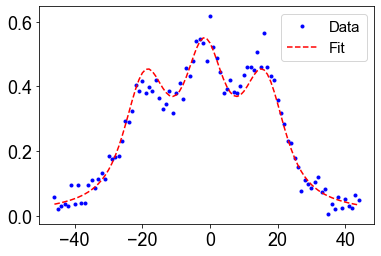

Fitted parameters:  [ 1.18585473e+01 -1.62608385e+00  1.49417515e-02  8.03063314e+00
  7.43213194e+00  1.75959629e+01  3.00029628e+00  5.37399868e+00]
Amplitude of the central Voigt profile: 11.858547310407102
Central frequency of the central Voigt profile: -1.6260838461455687
Standard deviation of the Gaussian part of the central Voigt profile: 0.0149417515430053
Half-width at half-maximum of the Lorentzian part of the central Voigt profile: 8.03063313678711
Amplitude of the side Voigt profiles: 7.432131938993229
Frequency separation of the side Voigt profiles from the central frequency: 17.595962883513337
Standard deviation of the Gaussian part of the side Voigt profiles: 3.000296280733155
Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: 5.373998677721774
Standard deviations:  [5.64394299e+00 1.92318063e-01 6.01010526e+02 5.33699182e+00
 2.50807771e+00 5.56130976e-01 1.13641837e+00 1.93754452e+00]
Standard deviation of the amplitude of the central Voigt p

In [76]:
import numpy as np
from scipy.special import wofz
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the Voigt profile
def voigt(x, amp, mu, sigma, gamma):
    z = ((x - mu) + 1j*gamma) / (sigma * np.sqrt(2))
    return amp * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))

# Define a combination of three Voigt profiles: one central and two side ones
def combined_voigt(x, amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s):
    # Central Voigt profile
    central = voigt(x, amp_c, mu_c, sigma_c, gamma_c)
    # Side Voigt profiles (symmetrically placed)
    side_left = voigt(x, amp_s, mu_c - delta_s, sigma_s, gamma_s)
    side_right = voigt(x, amp_s, mu_c + delta_s, sigma_s, gamma_s)
    # Combine them
    return central + side_left + side_right

# Generate some synthetic data (for demonstration)
x_data1 = FrequencyDetuning
y_data = ShelvingIntensityAverageArray_cleaned1

# Initial guesses for fitting parameters: [amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s]
# The fitting parameters are in the order of the function arguments, explained below:
# amp_c: amplitude of the central Voigt profile
# mu_c: central frequency of the central Voigt profile
# sigma_c: standard deviation of the Gaussian part of the central Voigt profile
# gamma_c: half-width at half-maximum of the Lorentzian part of the central Voigt profile
# amp_s: amplitude of the side Voigt profiles
# delta_s: frequency separation of the side Voigt profiles from the central frequency
# sigma_s: standard deviation of the Gaussian part of the side Voigt profiles
# gamma_s: half-width at half-maximum of the Lorentzian part of the side Voigt profiles
initial_guesses = [1.0, 1.0, 1.0, 0.5, 0.5, 5.0, 1.0, 0.5]

# Fit the combined Voigt profile to the data
popt1, pcov1 = curve_fit(combined_voigt, x_data1, y_data, p0=initial_guesses)

# Plot the result
plt.plot(x_data1, y_data, 'b.', label='Data')
plt.plot(x_data1, combined_voigt(x_data1, *popt1), 'r--', label='Fit')
plt.legend()
plt.show()

# Print the fitted parameters
print("Fitted parameters: ", popt1)

# List them out individually
print(f"Amplitude of the central Voigt profile: {popt1[0]}")
print(f"Central frequency of the central Voigt profile: {popt1[1]}")
print(f"Standard deviation of the Gaussian part of the central Voigt profile: {popt1[2]}")
print(f"Half-width at half-maximum of the Lorentzian part of the central Voigt profile: {popt1[3]}")
print(f"Amplitude of the side Voigt profiles: {popt1[4]}")
print(f"Frequency separation of the side Voigt profiles from the central frequency: {popt1[5]}")
print(f"Standard deviation of the Gaussian part of the side Voigt profiles: {popt1[6]}")
print(f"Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {popt1[7]}")

# Extract the pcov diagonal to get the standard deviations of the fitted parameters
perr1 = np.sqrt(np.diag(pcov1))

# Print the standard deviations
print("Standard deviations: ", perr1)

# List them out individually
print(f"Standard deviation of the amplitude of the central Voigt profile: {perr1[0]}")
print(f"Standard deviation of the central frequency of the central Voigt profile: {perr1[1]}")
print(f"Standard deviation of the standard deviation of the Gaussian part of the central Voigt profile: {perr1[2]}")
print(f"Standard deviation of the half-width at half-maximum of the Lorentzian part of the central Voigt profile: {perr1[3]}")
print(f"Standard deviation of the amplitude of the side Voigt profiles: {perr1[4]}")
print(f"Standard deviation of the frequency separation of the side Voigt profiles from the central frequency: {perr1[5]}")
print(f"Standard deviation of the standard deviation of the Gaussian part of the side Voigt profiles: {perr1[6]}")
print(f"Standard deviation of the half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {perr1[7]}")


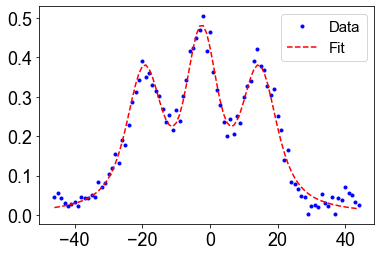

Fitted parameters:  [ 5.69703271 -2.45652999  3.19542977  2.54853489  6.44538033 16.97111467
  2.62884716  4.74304378]
Amplitude of the central Voigt profile: 5.697032706491262
Central frequency of the central Voigt profile: -2.4565299943067926
Standard deviation of the Gaussian part of the central Voigt profile: 3.1954297660362068
Half-width at half-maximum of the Lorentzian part of the central Voigt profile: 2.5485348861213413
Amplitude of the side Voigt profiles: 6.445380332921496
Frequency separation of the side Voigt profiles from the central frequency: 16.971114667020345
Standard deviation of the Gaussian part of the side Voigt profiles: 2.6288471573539276
Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: 4.743043775869186
Standard deviations of the fitted parameters:  [1.46035349 0.10857504 1.50175073 2.61926549 0.70551298 0.30252558
 0.64403712 0.65213697]
Standard deviation of the amplitude of the central Voigt profile: 1.4603534944980767
Standard d

In [78]:
import numpy as np
from scipy.special import wofz
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the Voigt profile
def voigt(x, amp, mu, sigma, gamma):
    z = ((x - mu) + 1j*gamma) / (sigma * np.sqrt(2))
    return amp * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))

# Define a combination of three Voigt profiles: one central and two side ones
def combined_voigt(x, amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s):
    # Central Voigt profile
    central = voigt(x, amp_c, mu_c, sigma_c, gamma_c)
    # Side Voigt profiles (symmetrically placed)
    side_left = voigt(x, amp_s, mu_c - delta_s, sigma_s, gamma_s)
    side_right = voigt(x, amp_s, mu_c + delta_s, sigma_s, gamma_s)
    # Combine them
    return central + side_left + side_right

# Generate some synthetic data (for demonstration)
x_data2 = FrequencyDetuning
y_data = ShelvingIntensityAverageArray_cleaned2

# Initial guesses for fitting parameters: [amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s]
# The fitting parameters are in the order of the function arguments, explained below:
# amp_c: amplitude of the central Voigt profile
# mu_c: central frequency of the central Voigt profile
# sigma_c: standard deviation of the Gaussian part of the central Voigt profile
# gamma_c: half-width at half-maximum of the Lorentzian part of the central Voigt profile
# amp_s: amplitude of the side Voigt profiles
# delta_s: frequency separation of the side Voigt profiles from the central frequency
# sigma_s: standard deviation of the Gaussian part of the side Voigt profiles
# gamma_s: half-width at half-maximum of the Lorentzian part of the side Voigt profiles
initial_guesses = [1.0, 1.0, 1.0, 0.5, 0.5, 5.0, 1.0, 0.5]

# Fit the combined Voigt profile to the data
popt2, pcov2 = curve_fit(combined_voigt, x_data2, y_data, p0=initial_guesses)

# Plot the result
plt.plot(x_data2, y_data, 'b.', label='Data')
plt.plot(x_data2, combined_voigt(x_data2, *popt2), 'r--', label='Fit')
plt.legend()
plt.show()


# Print the fitted parameters
print("Fitted parameters: ", popt2)

# List them out individually
print(f"Amplitude of the central Voigt profile: {popt2[0]}")
print(f"Central frequency of the central Voigt profile: {popt2[1]}")
print(f"Standard deviation of the Gaussian part of the central Voigt profile: {popt2[2]}")
print(f"Half-width at half-maximum of the Lorentzian part of the central Voigt profile: {popt2[3]}")
print(f"Amplitude of the side Voigt profiles: {popt2[4]}")
print(f"Frequency separation of the side Voigt profiles from the central frequency: {popt2[5]}")
print(f"Standard deviation of the Gaussian part of the side Voigt profiles: {popt2[6]}")
print(f"Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {popt2[7]}")

# Extract the pcov diagonal to get the standard deviations of the fitted parameters
perr2 = np.sqrt(np.diag(pcov2))
print("Standard deviations of the fitted parameters: ", perr2)

# List them out individually
print(f"Standard deviation of the amplitude of the central Voigt profile: {perr2[0]}")
print(f"Standard deviation of the central frequency of the central Voigt profile: {perr2[1]}")
print(f"Standard deviation of the standard deviation of the Gaussian part of the central Voigt profile: {perr2[2]}")
print(f"Standard deviation of the half-width at half-maximum of the Lorentzian part of the central Voigt profile: {perr2[3]}")
print(f"Standard deviation of the amplitude of the side Voigt profiles: {perr2[4]}")
print(f"Standard deviation of the frequency separation of the side Voigt profiles from the central frequency: {perr2[5]}")
print(f"Standard deviation of the standard deviation of the Gaussian part of the side Voigt profiles: {perr2[6]}")
print(f"Standard deviation of the half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {perr2[7]}")


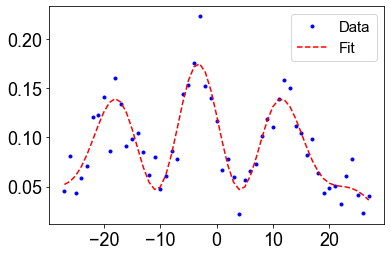

Fitted parameters:  [ 2.51884192e-07 -3.24663438e+00  1.36667675e+01 -7.58021221e+01
  1.97326337e+00  1.42472903e+01  1.78265209e+01 -1.67573987e+01]
Amplitude of the central Voigt profile: 2.518841924327762e-07
Central frequency of the central Voigt profile: -3.2466343792716414
Standard deviation of the Gaussian part of the central Voigt profile: 13.666767518618272
Half-width at half-maximum of the Lorentzian part of the central Voigt profile: -75.80212207344886
Amplitude of the side Voigt profiles: 1.9732633697896362
Frequency separation of the side Voigt profiles from the central frequency: 14.24729027484303
Standard deviation of the Gaussian part of the side Voigt profiles: 17.82652088945048
Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: -16.757398672807135
Standard deviations:  [2.41037688e-06 1.86571009e-01 3.92214918e+00 4.55261151e+01
 7.06571048e+00 9.04251022e+00 4.97828529e+01 1.56644232e+02]
Standard deviation of the amplitude of the central 

In [81]:
import numpy as np
from scipy.special import wofz
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the Voigt profile
def voigt(x, amp, mu, sigma, gamma):
    z = ((x - mu) + 1j*gamma) / (sigma * np.sqrt(2))
    return amp * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))

# Define a combination of three Voigt profiles: one central and two side ones
def combined_voigt(x, amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s):
    # Central Voigt profile
    central = voigt(x, amp_c, mu_c, sigma_c, gamma_c)
    # Side Voigt profiles (symmetrically placed)
    side_left = voigt(x, amp_s, mu_c - delta_s, sigma_s, gamma_s)
    side_right = voigt(x, amp_s, mu_c + delta_s, sigma_s, gamma_s)
    # Combine them
    return central + side_left + side_right

# Generate some synthetic data (for demonstration)
x_data3 = FrequencyDetuning[-72:-17]
y_data = ShelvingIntensityAverageArray_cleaned3[:-16]

# Initial guesses for fitting parameters: [amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s]
# The fitting parameters are in the order of the function arguments, explained below:
# amp_c: amplitude of the central Voigt profile
# mu_c: central frequency of the central Voigt profile
# sigma_c: standard deviation of the Gaussian part of the central Voigt profile
# gamma_c: half-width at half-maximum of the Lorentzian part of the central Voigt profile
# amp_s: amplitude of the side Voigt profiles
# delta_s: frequency separation of the side Voigt profiles from the central frequency
# sigma_s: standard deviation of the Gaussian part of the side Voigt profiles
# gamma_s: half-width at half-maximum of the Lorentzian part of the side Voigt profiles
initial_guesses = [1.0, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 0.5]

# Fit the combined Voigt profile to the data
popt3, pcov3 = curve_fit(combined_voigt, x_data3, y_data, p0=initial_guesses)

# Plot the result
plt.plot(x_data3, y_data, 'b.', label='Data')
plt.plot(x_data3, combined_voigt(x_data3, *popt3), 'r--', label='Fit')
plt.legend()
plt.show()

# Print the fitted parameters
print("Fitted parameters: ", popt3)

# List them out individually
print(f"Amplitude of the central Voigt profile: {popt3[0]}")
print(f"Central frequency of the central Voigt profile: {popt3[1]}")
print(f"Standard deviation of the Gaussian part of the central Voigt profile: {popt3[2]}")
print(f"Half-width at half-maximum of the Lorentzian part of the central Voigt profile: {popt3[3]}")
print(f"Amplitude of the side Voigt profiles: {popt3[4]}")
print(f"Frequency separation of the side Voigt profiles from the central frequency: {popt3[5]}")
print(f"Standard deviation of the Gaussian part of the side Voigt profiles: {popt3[6]}")
print(f"Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {popt3[7]}")

# Extract the pcov diagonal to get the standard deviations of the fitted parameters
perr3 = np.sqrt(np.diag(pcov3))

# Print the standard deviations
print("Standard deviations: ", perr3)

# List them out individually
print(f"Standard deviation of the amplitude of the central Voigt profile: {perr3[0]}")
print(f"Standard deviation of the central frequency of the central Voigt profile: {perr3[1]}")
print(f"Standard deviation of the standard deviation of the Gaussian part of the central Voigt profile: {perr3[2]}")
print(f"Standard deviation of the half-width at half-maximum of the Lorentzian part of the central Voigt profile: {perr3[3]}")
print(f"Standard deviation of the amplitude of the side Voigt profiles: {perr3[4]}")
print(f"Standard deviation of the frequency separation of the side Voigt profiles from the central frequency: {perr3[5]}")
print(f"Standard deviation of the standard deviation of the Gaussian part of the side Voigt profiles: {perr3[6]}")
print(f"Standard deviation of the half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {perr3[7]}")

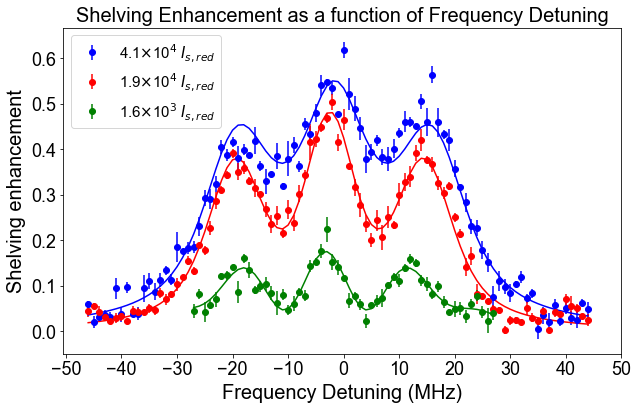

In [89]:
### ---------------------- PLOTTING ---------------------- ###

plt.figure(figsize=(10,6))

# convert x-axis to frequency detuning space in MHz, where the biggest shelving intensity is 0 detuning
FrequencyDetuning = np.arange(-np.argmax(ShelvingIntensityAverageArray_cleaned1), np.shape(ShelvingIntensityAverageArray_cleaned1)[0]-np.argmax(ShelvingIntensityAverageArray_cleaned1))
FrequencyDetuningGamma = FrequencyDetuning/7.5 # convert to units of x 10e3 Gamma_red (7.5kHz)

# plt.errorbar(range(len(ShelvingIntensityAverageArray)), ShelvingIntensityAverageArray, yerr=ShelvingIntensityUncertaintyArray, fmt='o')
plt.errorbar(FrequencyDetuning, ShelvingIntensityAverageArray_cleaned1, yerr=ShelvingIntensityUncertaintyArray_cleaned1, fmt='o',color='blue', label=r'4.1$\times$10$^4$ $I_{s,red}$')
plt.errorbar(FrequencyDetuning, ShelvingIntensityAverageArray_cleaned2, yerr=ShelvingIntensityUncertaintyArray_cleaned2, fmt='o', color='red', label=r'1.9$\times$10$^4$ $I_{s,red}$')
plt.errorbar(FrequencyDetuning[-72:-17], ShelvingIntensityAverageArray_cleaned3[:-16], yerr=ShelvingIntensityUncertaintyArray_cleaned3[:-16], fmt='o', color='green',label=r'1.6$\times$10$^3$ $I_{s,red}$')

plt.plot(FrequencyDetuning, combined_voigt(FrequencyDetuning, *popt1), 'b-')
plt.plot(FrequencyDetuning, combined_voigt(FrequencyDetuning, *popt2), 'r-')
plt.plot(FrequencyDetuning[-72:-17], combined_voigt(FrequencyDetuning[-72:-17], *popt3), 'g-')

plt.legend(loc='upper left')

plt.xticks(np.arange(-50, 51, 10))
plt.title('Shelving Enhancement as a function of Frequency Detuning')
plt.ylabel(r'Shelving enhancement')
plt.xlabel(r'Frequency Detuning (MHz)')

# plt.savefig('ShelvingEnhancementVsFrequencyDetuning2FittedDPI300.png', dpi=300)
# plt.savefig('ShelvingEnhancementVsFrequencyDetuning2FittedDPI300.pdf',dpi=300)

# 20241004 FREQUENCY OFFSET FROM CAVITY

Text(0.5, 0, 'Frequency offset from cavity (MHz)')

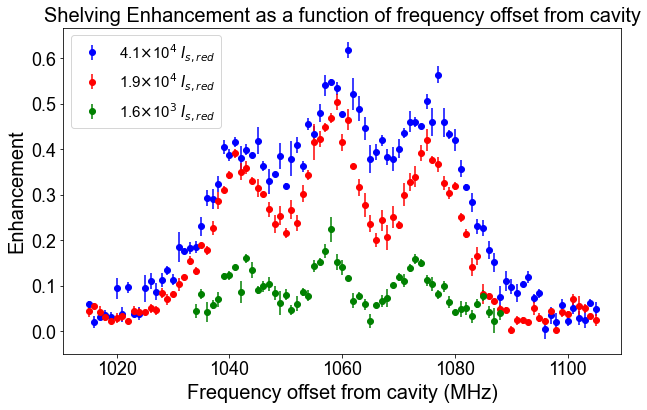

In [90]:
### ---------------------- CHANGE X AXIS TO UNITS OF MIRNY AND DPAOM FREQ ---------------------- ###

DPAOM_FREQ = 347.5 # in MHz
MIRNY_FREQ = np.arange(420,511,1) # in MHz
SUSERVO_AOM_OFFSET = 100 # in MHz

FrequencyOffsetFromCavity = MIRNY_FREQ + DPAOM_FREQ * 2 - SUSERVO_AOM_OFFSET

### ---------------------- PLOTTING ---------------------- ###

plt.figure(figsize=(10,6))

# convert x-axis to frequency detuning space in MHz, where the biggest shelving intensity is 0 detuning
FrequencyDetuning = np.arange(-np.argmax(ShelvingIntensityAverageArray_cleaned1), np.shape(ShelvingIntensityAverageArray_cleaned1)[0]-np.argmax(ShelvingIntensityAverageArray_cleaned1))
FrequencyDetuningGamma = FrequencyDetuning/7.5 # convert to units of x 10e3 Gamma_red (7.5kHz)

# plt.errorbar(range(len(ShelvingIntensityAverageArray)), ShelvingIntensityAverageArray, yerr=ShelvingIntensityUncertaintyArray, fmt='o')
plt.errorbar(FrequencyOffsetFromCavity, ShelvingIntensityAverageArray_cleaned1, yerr=ShelvingIntensityUncertaintyArray_cleaned1, fmt='o',color='blue', label=r'4.1$\times$10$^4$ $I_{s,red}$')
plt.errorbar(FrequencyOffsetFromCavity, ShelvingIntensityAverageArray_cleaned2, yerr=ShelvingIntensityUncertaintyArray_cleaned2, fmt='o', color='red', label=r'1.9$\times$10$^4$ $I_{s,red}$')
plt.errorbar(FrequencyOffsetFromCavity[-72:-17], ShelvingIntensityAverageArray_cleaned3[:-16], yerr=ShelvingIntensityUncertaintyArray_cleaned3[:-16], fmt='o', color='green',label=r'1.6$\times$10$^3$ $I_{s,red}$')
plt.legend(loc='upper left')

# plt.xticks(np.arange(-50, 51, 10))
plt.title('Shelving Enhancement as a function of frequency offset from cavity')
plt.ylabel(r'Enhancement')
plt.xlabel(r'Frequency offset from cavity (MHz)')


# Fitting

## Frequency offset from cavity

C:\Users\Michael\AppData\Local\Temp/ipykernel_28168/4014913597.py:9: RuntimeWarning: overflow encountered in multiply
  return amp * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))


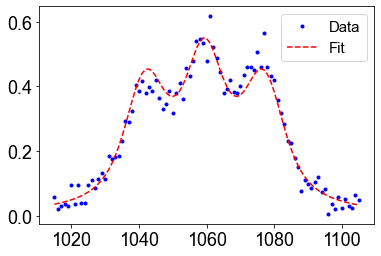

Fitted parameters:  [1.18585044e+01 1.05937392e+03 6.38809893e-03 8.03064129e+00
 7.43215884e+00 1.75959512e+01 3.00029469e+00 5.37402098e+00]
Amplitude of the central Voigt profile: 11.858504411166548
Central frequency of the central Voigt profile: 1059.3739162197814
Standard deviation of the Gaussian part of the central Voigt profile: 0.006388098928446972
Half-width at half-maximum of the Lorentzian part of the central Voigt profile: 8.030641291055467
Amplitude of the side Voigt profiles: 7.432158841695629
Frequency separation of the side Voigt profiles from the central frequency: 17.59595115438672
Standard deviation of the Gaussian part of the side Voigt profiles: 3.0002946902737144
Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: 5.374020981630825
Standard deviations:  [5.50405399e+00 1.92318778e-01 1.55892422e+03 5.22154557e+00
 2.46207979e+00 5.48711090e-01 1.13691380e+00 1.91320975e+00]
Standard deviation of the amplitude of the central Voigt profile

In [91]:
import numpy as np
from scipy.special import wofz
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the Voigt profile
def voigt(x, amp, mu, sigma, gamma):
    z = ((x - mu) + 1j*gamma) / (sigma * np.sqrt(2))
    return amp * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))

# Define a combination of three Voigt profiles: one central and two side ones
def combined_voigt(x, amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s):
    # Central Voigt profile
    central = voigt(x, amp_c, mu_c, sigma_c, gamma_c)
    # Side Voigt profiles (symmetrically placed)
    side_left = voigt(x, amp_s, mu_c - delta_s, sigma_s, gamma_s)
    side_right = voigt(x, amp_s, mu_c + delta_s, sigma_s, gamma_s)
    # Combine them
    return central + side_left + side_right

# Generate some synthetic data (for demonstration)
x_data1 = FrequencyOffsetFromCavity
y_data = ShelvingIntensityAverageArray_cleaned1

# Initial guesses for fitting parameters: [amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s]
# The fitting parameters are in the order of the function arguments, explained below:
# amp_c: amplitude of the central Voigt profile
# mu_c: central frequency of the central Voigt profile
# sigma_c: standard deviation of the Gaussian part of the central Voigt profile
# gamma_c: half-width at half-maximum of the Lorentzian part of the central Voigt profile
# amp_s: amplitude of the side Voigt profiles
# delta_s: frequency separation of the side Voigt profiles from the central frequency
# sigma_s: standard deviation of the Gaussian part of the side Voigt profiles
# gamma_s: half-width at half-maximum of the Lorentzian part of the side Voigt profiles
initial_guesses = [15.0, 1060.0, 1.0, 0.5, 0.5, 5.0, 1.0, 0.5]

# Fit the combined Voigt profile to the data
popt1, pcov1 = curve_fit(combined_voigt, x_data1, y_data, p0=initial_guesses)

# Plot the result
plt.plot(x_data1, y_data, 'b.', label='Data')
plt.plot(x_data1, combined_voigt(x_data1, *popt1), 'r--', label='Fit')
plt.legend()
plt.show()

# Print the fitted parameters
print("Fitted parameters: ", popt1)

# List them out individually
print(f"Amplitude of the central Voigt profile: {popt1[0]}")
print(f"Central frequency of the central Voigt profile: {popt1[1]}")
print(f"Standard deviation of the Gaussian part of the central Voigt profile: {popt1[2]}")
print(f"Half-width at half-maximum of the Lorentzian part of the central Voigt profile: {popt1[3]}")
print(f"Amplitude of the side Voigt profiles: {popt1[4]}")
print(f"Frequency separation of the side Voigt profiles from the central frequency: {popt1[5]}")
print(f"Standard deviation of the Gaussian part of the side Voigt profiles: {popt1[6]}")
print(f"Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {popt1[7]}")

# Extract the pcov diagonal to get the standard deviations of the fitted parameters
perr1 = np.sqrt(np.diag(pcov1))

# Print the standard deviations
print("Standard deviations: ", perr1)

# List them out individually
print(f"Standard deviation of the amplitude of the central Voigt profile: {perr1[0]}")
print(f"Standard deviation of the central frequency of the central Voigt profile: {perr1[1]}")
print(f"Standard deviation of the standard deviation of the Gaussian part of the central Voigt profile: {perr1[2]}")
print(f"Standard deviation of the half-width at half-maximum of the Lorentzian part of the central Voigt profile: {perr1[3]}")
print(f"Standard deviation of the amplitude of the side Voigt profiles: {perr1[4]}")
print(f"Standard deviation of the frequency separation of the side Voigt profiles from the central frequency: {perr1[5]}")
print(f"Standard deviation of the standard deviation of the Gaussian part of the side Voigt profiles: {perr1[6]}")
print(f"Standard deviation of the half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {perr1[7]}")


C:\Users\Michael\AppData\Local\Temp/ipykernel_28168/2767742261.py:9: RuntimeWarning: overflow encountered in true_divide
  return amp * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))


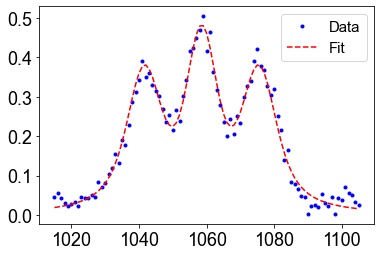

Fitted parameters:  [   5.69707641 1058.5434713     3.19538961    2.54860959    6.44535766
   16.97112178    2.62885244    4.74302501]
Amplitude of the central Voigt profile: 5.697076414321834
Central frequency of the central Voigt profile: 1058.543471301707
Standard deviation of the Gaussian part of the central Voigt profile: 3.195389606613879
Half-width at half-maximum of the Lorentzian part of the central Voigt profile: 2.548609588175197
Amplitude of the side Voigt profiles: 6.4453576567943225
Frequency separation of the side Voigt profiles from the central frequency: 16.97112177966633
Standard deviation of the Gaussian part of the side Voigt profiles: 2.6288524413980836
Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: 4.743025011935332
Standard deviations of the fitted parameters:  [1.46037861 0.10857532 1.50177994 2.61925909 0.70552162 0.30252407
 0.64401684 0.65215013]
Standard deviation of the amplitude of the central Voigt profile: 1.460378611846144

In [92]:
import numpy as np
from scipy.special import wofz
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the Voigt profile
def voigt(x, amp, mu, sigma, gamma):
    z = ((x - mu) + 1j*gamma) / (sigma * np.sqrt(2))
    return amp * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))

# Define a combination of three Voigt profiles: one central and two side ones
def combined_voigt(x, amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s):
    # Central Voigt profile
    central = voigt(x, amp_c, mu_c, sigma_c, gamma_c)
    # Side Voigt profiles (symmetrically placed)
    side_left = voigt(x, amp_s, mu_c - delta_s, sigma_s, gamma_s)
    side_right = voigt(x, amp_s, mu_c + delta_s, sigma_s, gamma_s)
    # Combine them
    return central + side_left + side_right

# Generate some synthetic data (for demonstration)
x_data2 = FrequencyOffsetFromCavity
y_data = ShelvingIntensityAverageArray_cleaned2

# Initial guesses for fitting parameters: [amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s]
# The fitting parameters are in the order of the function arguments, explained below:
# amp_c: amplitude of the central Voigt profile
# mu_c: central frequency of the central Voigt profile
# sigma_c: standard deviation of the Gaussian part of the central Voigt profile
# gamma_c: half-width at half-maximum of the Lorentzian part of the central Voigt profile
# amp_s: amplitude of the side Voigt profiles
# delta_s: frequency separation of the side Voigt profiles from the central frequency
# sigma_s: standard deviation of the Gaussian part of the side Voigt profiles
# gamma_s: half-width at half-maximum of the Lorentzian part of the side Voigt profiles
initial_guesses = [1.0, 1060.0, 1.0, 0.5, 0.5, 5.0, 1.0, 0.5]

# Fit the combined Voigt profile to the data
popt2, pcov2 = curve_fit(combined_voigt, x_data2, y_data, p0=initial_guesses)

# Plot the result
plt.plot(x_data2, y_data, 'b.', label='Data')
plt.plot(x_data2, combined_voigt(x_data2, *popt2), 'r--', label='Fit')
plt.legend()
plt.show()


# Print the fitted parameters
print("Fitted parameters: ", popt2)

# List them out individually
print(f"Amplitude of the central Voigt profile: {popt2[0]}")
print(f"Central frequency of the central Voigt profile: {popt2[1]}")
print(f"Standard deviation of the Gaussian part of the central Voigt profile: {popt2[2]}")
print(f"Half-width at half-maximum of the Lorentzian part of the central Voigt profile: {popt2[3]}")
print(f"Amplitude of the side Voigt profiles: {popt2[4]}")
print(f"Frequency separation of the side Voigt profiles from the central frequency: {popt2[5]}")
print(f"Standard deviation of the Gaussian part of the side Voigt profiles: {popt2[6]}")
print(f"Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {popt2[7]}")

# Extract the pcov diagonal to get the standard deviations of the fitted parameters
perr2 = np.sqrt(np.diag(pcov2))
print("Standard deviations of the fitted parameters: ", perr2)

# List them out individually
print(f"Standard deviation of the amplitude of the central Voigt profile: {perr2[0]}")
print(f"Standard deviation of the central frequency of the central Voigt profile: {perr2[1]}")
print(f"Standard deviation of the standard deviation of the Gaussian part of the central Voigt profile: {perr2[2]}")
print(f"Standard deviation of the half-width at half-maximum of the Lorentzian part of the central Voigt profile: {perr2[3]}")
print(f"Standard deviation of the amplitude of the side Voigt profiles: {perr2[4]}")
print(f"Standard deviation of the frequency separation of the side Voigt profiles from the central frequency: {perr2[5]}")
print(f"Standard deviation of the standard deviation of the Gaussian part of the side Voigt profiles: {perr2[6]}")
print(f"Standard deviation of the half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {perr2[7]}")


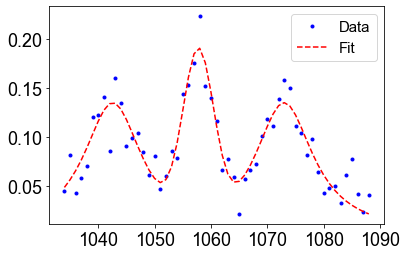

Fitted parameters:  [ 8.42995520e-01  1.05776872e+03  3.07881332e+00 -1.19277331e+00
  2.59382861e+00  1.52136105e+01  4.06415180e-05  6.27403304e+00]
Amplitude of the central Voigt profile: 0.8429955198220282
Central frequency of the central Voigt profile: 1057.7687203159198
Standard deviation of the Gaussian part of the central Voigt profile: 3.0788133212144166
Half-width at half-maximum of the Lorentzian part of the central Voigt profile: -1.192773314024313
Amplitude of the side Voigt profiles: 2.5938286092806133
Frequency separation of the side Voigt profiles from the central frequency: 15.213610537037315
Standard deviation of the Gaussian part of the side Voigt profiles: 4.064151803010482e-05
Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: 6.2740330422060735
Standard deviations:  [ 0.31881808  0.17947643  0.99402418  2.35952898  0.24220663  0.42755118
 95.21353648  0.69155435]
Standard deviation of the amplitude of the central Voigt profile: 0.3188180

In [93]:
import numpy as np
from scipy.special import wofz
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the Voigt profile
def voigt(x, amp, mu, sigma, gamma):
    z = ((x - mu) + 1j*gamma) / (sigma * np.sqrt(2))
    return amp * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))

# Define a combination of three Voigt profiles: one central and two side ones
def combined_voigt(x, amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s):
    # Central Voigt profile
    central = voigt(x, amp_c, mu_c, sigma_c, gamma_c)
    # Side Voigt profiles (symmetrically placed)
    side_left = voigt(x, amp_s, mu_c - delta_s, sigma_s, gamma_s)
    side_right = voigt(x, amp_s, mu_c + delta_s, sigma_s, gamma_s)
    # Combine them
    return central + side_left + side_right

# Generate some synthetic data (for demonstration)
x_data3 = FrequencyOffsetFromCavity[-72:-17]
y_data = ShelvingIntensityAverageArray_cleaned3[:-16]

# Initial guesses for fitting parameters: [amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s]
# The fitting parameters are in the order of the function arguments, explained below:
# amp_c: amplitude of the central Voigt profile
# mu_c: central frequency of the central Voigt profile
# sigma_c: standard deviation of the Gaussian part of the central Voigt profile
# gamma_c: half-width at half-maximum of the Lorentzian part of the central Voigt profile
# amp_s: amplitude of the side Voigt profiles
# delta_s: frequency separation of the side Voigt profiles from the central frequency
# sigma_s: standard deviation of the Gaussian part of the side Voigt profiles
# gamma_s: half-width at half-maximum of the Lorentzian part of the side Voigt profiles
initial_guesses = [0.1, 1057.0, 3, 3, 0.1, 15, 1.0, 0.1]

# Fit the combined Voigt profile to the data
popt3, pcov3 = curve_fit(combined_voigt, x_data3, y_data, p0=initial_guesses)

# Plot the result
plt.plot(x_data3, y_data, 'b.', label='Data')
plt.plot(x_data3, combined_voigt(x_data3, *popt3), 'r--', label='Fit')
plt.legend()
plt.show()

# Print the fitted parameters
print("Fitted parameters: ", popt3)

# List them out individually
print(f"Amplitude of the central Voigt profile: {popt3[0]}")
print(f"Central frequency of the central Voigt profile: {popt3[1]}")
print(f"Standard deviation of the Gaussian part of the central Voigt profile: {popt3[2]}")
print(f"Half-width at half-maximum of the Lorentzian part of the central Voigt profile: {popt3[3]}")
print(f"Amplitude of the side Voigt profiles: {popt3[4]}")
print(f"Frequency separation of the side Voigt profiles from the central frequency: {popt3[5]}")
print(f"Standard deviation of the Gaussian part of the side Voigt profiles: {popt3[6]}")
print(f"Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {popt3[7]}")

# Extract the pcov diagonal to get the standard deviations of the fitted parameters
perr3 = np.sqrt(np.diag(pcov3))

# Print the standard deviations
print("Standard deviations: ", perr3)

# List them out individually
print(f"Standard deviation of the amplitude of the central Voigt profile: {perr3[0]}")
print(f"Standard deviation of the central frequency of the central Voigt profile: {perr3[1]}")
print(f"Standard deviation of the standard deviation of the Gaussian part of the central Voigt profile: {perr3[2]}")
print(f"Standard deviation of the half-width at half-maximum of the Lorentzian part of the central Voigt profile: {perr3[3]}")
print(f"Standard deviation of the amplitude of the side Voigt profiles: {perr3[4]}")
print(f"Standard deviation of the frequency separation of the side Voigt profiles from the central frequency: {perr3[5]}")
print(f"Standard deviation of the standard deviation of the Gaussian part of the side Voigt profiles: {perr3[6]}")
print(f"Standard deviation of the half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {perr3[7]}")

Text(0.5, 0, 'Frequency offset from cavity (MHz)')

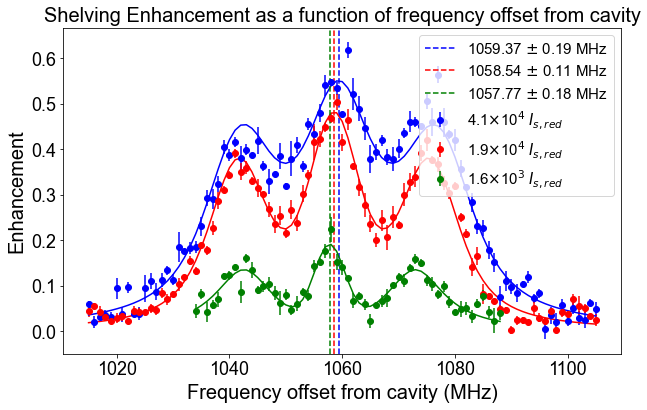

In [94]:
### ---------------------- CHANGE X AXIS TO UNITS OF MIRNY AND DPAOM FREQ ---------------------- ###

DPAOM_FREQ = 347.5 # in MHz
MIRNY_FREQ = np.arange(420,511,1) # in MHz
SUSERVO_AOM_OFFSET = 100 # in MHz

FrequencyOffsetFromCavity = MIRNY_FREQ + DPAOM_FREQ * 2 - SUSERVO_AOM_OFFSET

### ---------------------- PLOTTING ---------------------- ###

plt.figure(figsize=(10,6))

# convert x-axis to frequency detuning space in MHz, where the biggest shelving intensity is 0 detuning
FrequencyDetuning = np.arange(-np.argmax(ShelvingIntensityAverageArray_cleaned1), np.shape(ShelvingIntensityAverageArray_cleaned1)[0]-np.argmax(ShelvingIntensityAverageArray_cleaned1))
FrequencyDetuningGamma = FrequencyDetuning/7.5 # convert to units of x 10e3 Gamma_red (7.5kHz)

# plt.errorbar(range(len(ShelvingIntensityAverageArray)), ShelvingIntensityAverageArray, yerr=ShelvingIntensityUncertaintyArray, fmt='o')
plt.errorbar(FrequencyOffsetFromCavity, ShelvingIntensityAverageArray_cleaned1, yerr=ShelvingIntensityUncertaintyArray_cleaned1, fmt='o',color='blue', label=r'4.1$\times$10$^4$ $I_{s,red}$')
plt.errorbar(FrequencyOffsetFromCavity, ShelvingIntensityAverageArray_cleaned2, yerr=ShelvingIntensityUncertaintyArray_cleaned2, fmt='o', color='red', label=r'1.9$\times$10$^4$ $I_{s,red}$')
plt.errorbar(FrequencyOffsetFromCavity[-72:-17], ShelvingIntensityAverageArray_cleaned3[:-16], yerr=ShelvingIntensityUncertaintyArray_cleaned3[:-16], fmt='o', color='green',label=r'1.6$\times$10$^3$ $I_{s,red}$')

plt.plot(FrequencyOffsetFromCavity, combined_voigt(FrequencyOffsetFromCavity, *popt1), 'b-')
plt.axvline(x=popt1[1], color='b', linestyle='--', label=r'%.2f $\pm$ %.2f MHz' %(popt1[1],perr1[1]))
plt.plot(FrequencyOffsetFromCavity, combined_voigt(FrequencyOffsetFromCavity, *popt2), 'r-')
plt.axvline(x=popt2[1], color='r', linestyle='--', label=r'%.2f $\pm$ %.2f MHz' %(popt2[1],perr2[1]))
plt.plot(FrequencyOffsetFromCavity[-72:-17], combined_voigt(FrequencyOffsetFromCavity[-72:-17], *popt3), 'g-')
plt.axvline(x=popt3[1], color='g', linestyle='--', label=r'%.2f $\pm$ %.2f MHz' %(popt3[1],perr3[1]))

plt.legend()

# plt.xticks(np.arange(-50, 51, 10))
plt.title('Shelving Enhancement as a function of frequency offset from cavity')
plt.ylabel(r'Enhancement')
plt.xlabel(r'Frequency offset from cavity (MHz)')